In [1]:
from IPython import get_ipython
import io


def is_jupyter():
    """
    
    This function helps us detecct the juypter environment
    
    """
    try:
        shell = get_ipython().__class__.__name__
        return shell in ('ZMQInteractiveShell', 'Shell')
    except NameError:
        return False


if is_jupyter():
    """
    This is a conditional import for jupyter notebook
    """
    from IPython.display import Image as IPyImage, display


    def show_image(obj):
        if isinstance(obj, bytes):
            img = IPyImage(data=obj)
        else:
            img = IPyImage(filename=obj)
        display(img)

else:
    from PIL import Image as PILImage


    def show_image(obj):
        if isinstance(obj, bytes):
            img = PILImage.open(io.BytesIO(obj))
        else:
            img = PILImage.open(obj)
        img.show()

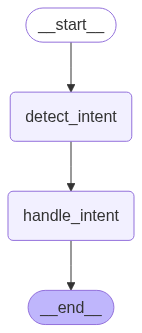

Example 1:
User: square 10
AI: The square of 10 is 100.

Example 2:
User: square 10
AI: The square of 10 is 100.
User: greet Alice
AI: Hi there, Alice!


In [2]:
from typing import TypedDict, Union, Optional, Any, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage


# ======================
# 1) Define TypedDict for LangGraph state
# ======================
class ConversationState(TypedDict):
    user_input: str
    last_intent: Optional[str]
    message_count: int
    messages: List[Union[HumanMessage, AIMessage]]
    debug_info: Any


# ======================
# 2) Seed state
# ======================
state: ConversationState = {
    "user_input": "square 5",
    "last_intent": None,
    "message_count": 0,
    "messages": [],
    "debug_info": {}
}


# ======================
# 3) Functions using Union, Optional, Any, Lambda
# ======================
def square(x: Union[int, float]) -> float:
    return x * x


def nice_message(name: Optional[str]) -> None:
    if name is None:
        print("Hey random person!")
    else:
        print(f"Hi there, {name}!")


def print_value(x: Any) -> None:
    print(f"Debug: {x}")


nums = [1, 2, 3, 4]
squares = list(map(lambda x: x * x, nums))  # Lambda example


# ======================
# 4) LangGraph Nodes
# ======================
def detect_intent(state: ConversationState) -> ConversationState:
    text = state["user_input"].lower()
    if text.startswith("square"):
        state["last_intent"] = "SquareNumber"
    elif text.startswith("greet"):
        state["last_intent"] = "GreetUser"
    else:
        state["last_intent"] = "UnknownIntent"

    state["debug_info"]["detected_intent"] = state["last_intent"]
    state["messages"].append(HumanMessage(content=state["user_input"]))
    state["message_count"] += 1
    return state


def handle_intent(state: ConversationState) -> ConversationState:
    intent = state["last_intent"]

    if intent == "SquareNumber":
        parts = state["user_input"].split()
        if len(parts) > 1 and parts[1].isdigit():
            num = int(parts[1])
            result = square(num)
            reply = f"The square of {num} is {result}."
        else:
            reply = "Please provide a number to square."
        state["messages"].append(AIMessage(content=reply))

    elif intent == "GreetUser":
        parts = state["user_input"].split(maxsplit=1)
        name = parts[1] if len(parts) > 1 else None
        reply = "Hey random person!" if name is None else f"Hi there, {name}!"
        state["messages"].append(AIMessage(content=reply))

    else:
        state["messages"].append(AIMessage(content="I didn't understand that."))

    state["message_count"] += 1
    return state


# ======================
# 5) Build LangGraph
# ======================
graph = StateGraph(ConversationState)
graph.add_node("detect_intent", detect_intent)
graph.add_node("handle_intent", handle_intent)

graph.set_entry_point("detect_intent")
graph.add_edge("detect_intent", "handle_intent")
graph.add_edge("handle_intent", END)

app = graph.compile()

show_image(app.get_graph().draw_mermaid_png())

if __name__ == "__main__":
    # Example 1: square number
    output1 = app.invoke({**state, "user_input": "square 10"})
    print("Example 1:")
    for msg in output1["messages"]:
        role = "User" if isinstance(msg, HumanMessage) else "AI"
        print(f"{role}: {msg.content}")

    # Example 2: greet user
    output2 = app.invoke({**state, "user_input": "greet Alice"})
    print("\nExample 2:")
    for msg in output2["messages"]:
        role = "User" if isinstance(msg, HumanMessage) else "AI"
        print(f"{role}: {msg.content}")
